In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6 MB 4.7 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=ba9ea1be6d09fcc32bf8de8a1c10ddab5b198f69331305b229779f3d368f4c34
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/de/11/0a038be70c2c212ce45fa0f4f9da165bb5dd87de1288394dc3
Successfully built pyLDAvis


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src import lda_utils, nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Import Dataset and LDA Model Inputs

In [7]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')
wallstreet['lemmatized_tokens'] = wallstreet['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))

In [18]:
n_topics = 20
max_doc_freq = 0.7
max_features = 10000
max_iterations = 25

docs_raw = [' '.join(d) for d in wallstreet['lemmatized_tokens']]

--- 
# Bag of Words

In [ ]:
vectorizer = CountVectorizer(max_features=max_feats, max_df=freq_thresh)
docs_vectorized = vectorizer.fit_transform(docs_raw)

In [20]:
# Must be even for visualizations.

lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = lda_utils.convert_to_bow_and_fit_lda_model(docs_raw, max_features, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

In [21]:
lda_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
order vendor support dispute wallet day market time buyer address

Topic #1:
use mirror per euro onionshop pill ml ghb mg liquid

Topic #2:
profile onion kallashnikov black wallstyizjhkrvmj weed high supplier rated boat

Topic #3:
like know make people time wrote money good one vendor

Topic #4:
contact allowed external link rule read wrote market forum pm

Topic #5:
card cc credit use fullz debit gift dump self carding

Topic #6:
address name number phone way free info card information become

Topic #7:
account paypal transfer fee bitcoin fund pay money transaction amount

Topic #8:
need looking bank buy btc uk drop account cash transfer

Topic #9:
pgp message signature begin drug consider ice arab sand smashed

Topic #10:
guide cashout bank offer record ssn pack extra link money

Topic #11:
product order shipping price quality market offer free vendor best

Topic #12:
credit visa account external rule mastercard vendor trade bank contact

Topic #13:
wsm help rule phished w

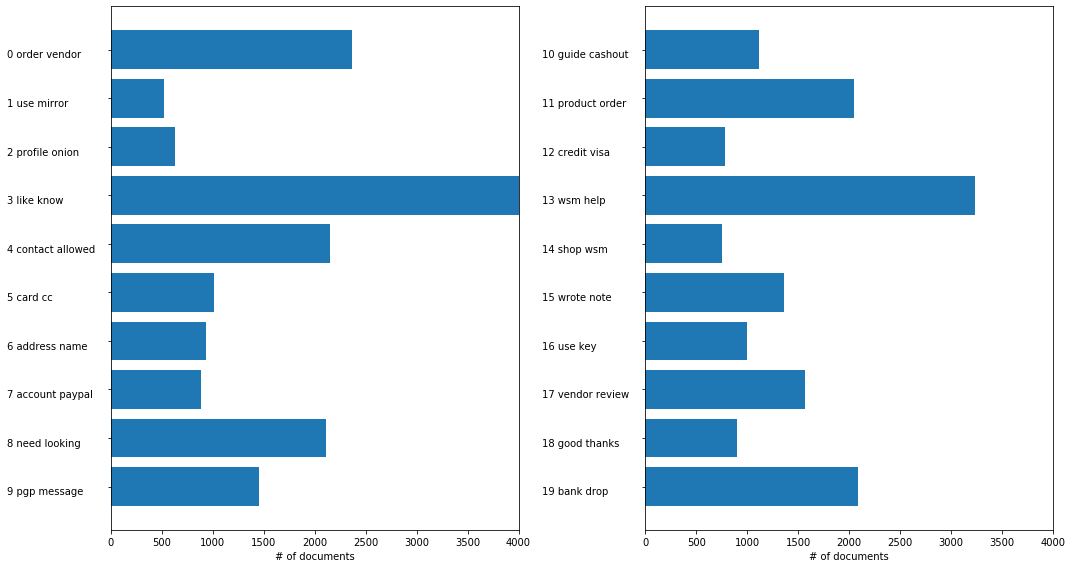

In [22]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 4000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [23]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.140116  0.122901       1        1  17.849892
0      0.095485  0.106678       2        1   7.379877
11     0.053031 -0.002007       3        1   6.587487
16     0.139192 -0.066178       4        1   6.044412
17     0.106558 -0.006363       5        1   5.829482
19     0.005129  0.151585       6        1   5.661658
15     0.172900  0.063680       7        1   5.638513
10    -0.031378  0.066147       8        1   5.632181
8      0.039382  0.112367       9        1   5.134741
13    -0.213230  0.119554      10        1   4.696396
5      0.096070 -0.002881      11        1   4.358504
6      0.099741 -0.069905      12        1   4.282708
4     -0.177559  0.157827      13        1   4.209129
9     -0.176341 -0.109844      14        1   3.395956
7      0.043532  0.002836      15        1   3.272813
14     0.019997 -0.128904      16        1   2.966303
12    -0.317445  0.002639      17        1   2.335956
1      0.016551 -0.318244      18        1   1.741271
18    -0.010532 -0.022329      19        1   1.618748
2     -0.101200 -0.179560      20        1   1.363974, topic_info=         Term         Freq        Total Category  logprob  loglift
9860      wsm  7625.000000  7625.000000  Default  30.0000  30.0000
4118     help  6419.000000  6419.000000  Default  29.0000  29.0000
1971  contact  4978.000000  4978.000000  Default  28.0000  28.0000
7633     rule  5969.000000  5969.000000  Default  27.0000  27.0000
6519      pgp  3808.000000  3808.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
331    amazon   100.714159   435.118115  Topic20  -4.9761   2.8314
1640      com   105.703343   607.350332  Topic20  -4.9278   2.5463
6119    offer   134.546101  5147.071828  Topic20  -4.6865   0.6505
5914      new   102.716141  4455.130209  Topic20  -4.9564   0.5249
6441   paypal    95.289100  1702.557672  Topic20  -5.0315   1.4118

[1458 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1        12  0.411865         ___
1        15  0.585621         ___
7         3  0.989652         aaa
14       17  0.978057        aber
29        1  0.015985  absolutely
...     ...       ...         ...
9975     12  0.800175         zip
9975     16  0.007241         zip
9981     17  0.991249          zu
9990      2  0.939343    автоматы
9994      2  0.939343     игровые

[4628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 12, 17, 18, 20, 16, 11, 9, 14, 6, 7, 5, 10, 8, 15, 13, 2, 19, 3])

### Model Performance

In [24]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

Log Likelihood:  -7507504.259827259
Perplexity:  1191.1065774767085
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


---
# TF-IDF

In [29]:
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = lda_utils.calculate_tfidf_and_fit_lda_model(docs_raw, max_features, max_doc_freq, 
                                                                                                                   n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

In [30]:
lda_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)


Topic #0:
met dxm lotto profile brand offer method need guide money

Topic #1:
indoor price done hi bob mdma best hacker ich bulk

Topic #2:
bump store wsm market welcome boat phished rule profile help

Topic #3:
vendor order wrote like know time money make good one

Topic #4:
contact allowed external read link rule interested jabber wrote click

Topic #5:
fullz card offer scan interested stock cc gift legit dl

Topic #6:
deal become rebellion unfree existence act absolutely world way free

Topic #7:
wall high street yourmomsbox tier legendary top renown care live

Topic #8:
bank drop account paypal transfer looking need cash card uk

Topic #9:
pgp begin signature message arab nun sand smashed testicle eskimo

Topic #10:
guide cashout bank record ssn pack extra offer link sale

Topic #11:
ship number nbome best hcl product communication deliver priority quality

Topic #12:
rule phished help wsm external vendor account allowed contact broder

Topic #13:
online marketplace vouch po manu

In [31]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.182955  0.057173       1        1  30.032971
17    -0.091986  0.069156       2        1  16.457868
16    -0.169818  0.088267       3        1   7.274582
8     -0.178556  0.096836       4        1   5.841826
12    -0.121979 -0.269741       5        1   4.964819
9      0.029432 -0.183411       6        1   3.935145
4     -0.145703 -0.057639       7        1   3.790225
10    -0.015573  0.101623       8        1   3.781847
15    -0.088399 -0.049114       9        1   3.590789
5     -0.091397  0.092471      10        1   3.416987
2      0.065383 -0.261351      11        1   2.775279
6      0.074292 -0.049268      12        1   2.270459
1      0.134612  0.057979      13        1   1.721374
18     0.100784  0.055986      14        1   1.648000
14     0.092119 -0.007712      15        1   1.636997
11     0.170523  0.038755      16        1   1.615961
13     0.031365  0.058203      17        1   1.584726
19     0.041995  0.071762      18        1   1.359859
7      0.179535  0.036437      19        1   1.190449
0      0.166328  0.053588      20        1   1.109836, topic_info=         Term        Freq       Total Category  logprob  loglift
9860      wsm  969.000000  969.000000  Default  30.0000  30.0000
7633     rule  816.000000  816.000000  Default  29.0000  29.0000
1156     bump  423.000000  423.000000  Default  28.0000  28.0000
6519      pgp  484.000000  484.000000  Default  27.0000  27.0000
6533  phished  632.000000  632.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1594  cocaine    9.023101   79.229196  Topic20  -5.1216   2.3284
980      blue    5.396413   22.268280  Topic20  -5.6356   3.0835
4062     hash    7.600754  137.370665  Topic20  -5.2931   1.6065
9653     weed    7.464471  134.813399  Topic20  -5.3112   1.6072
5394   market    6.068143  793.084548  Topic20  -5.5183  -0.3719

[1266 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1        12  0.105119          ___
1        16  0.840951          ___
8         1  0.378514           ab
8         2  0.189257           ab
8         3  0.120436           ab
...     ...       ...          ...
9948     19  0.948345  yourmomsbox
9959      3  0.107468          yup
9959      9  0.644807          yup
9959     13  0.107468          yup
9968      4  0.938876        zelle

[3987 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 18, 17, 9, 13, 10, 5, 11, 16, 6, 3, 7, 2, 19, 15, 12, 14, 20, 8, 1])

In [32]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

Log Likelihood:  -1132308.0
Perplexity:  7846.83
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
